In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from UCB_discrete import UCB_clinical, UCB1_os_clinical
from collections import defaultdict
from Environment import Clinical_env
from SimulatedGames import simulate
from ipywidgets import IntProgress
from IPython.display import display
import plots

%matplotlib inline

## Applications of HazardUCB 

For clinical experiments, for cancer patients (samples), there are several treatments (arms), the reward is how long can a patient survive after the treatment (rewards). The goal is to minimize the sub-optimal treatment. This is in the field of survival analysis, thus the hazard rate assumption and medians are good choice.

Data: Glinoma (cancer) clininal data from Broad Institute Firehouse https://gdac.broadinstitute.org/

In [2]:
data = pd.read_csv('gdac.broadinstitute.org_GBMLGG.Clinical_Pick_Tier1.Level_4.2016012800.0.0/GBMLGG.clin.merged.picked.txt', delimiter= "\t", header = 0)
data = data.T
data.columns = data.iloc[0]
data = data.drop(data.index[0])
data.head()

Hybridization REF,Composite Element REF,years_to_birth,vital_status,days_to_death,days_to_last_followup,tumor_tissue_site,gender,date_of_initial_pathologic_diagnosis,days_to_last_known_alive,radiation_therapy,karnofsky_performance_score,histological_type,race,ethnicity
tcga-06-6391,value,44,1,45,NaN,brain,female,2011,NaN,no,NaN,untreated primary (de novo) gbm,white,not hispanic or latino
tcga-19-a6j4,value,68,1,121,NaN,brain,male,2013,NaN,NaN,NaN,glioblastoma multiforme (gbm),black or african american,not hispanic or latino
tcga-cs-6665,value,51,0,NaN,1568,central nervous system,female,2010,NaN,yes,90,astrocytoma,white,not hispanic or latino
tcga-cs-6670,value,43,0,NaN,1426,central nervous system,male,2011,NaN,NaN,NaN,oligodendroglioma,white,not hispanic or latino
tcga-db-a4xc,value,26,0,NaN,1421,central nervous system,male,2010,NaN,yes,NaN,oligoastrocytoma,white,not hispanic or latino


### Explain columns

'days_to_death': rewards (lifetime distributions)  
'radiation_therapy': two arms (yea/no)
    
needs to drop NaN

In [3]:
days_to_death_with_radiation = data.groupby(['radiation_therapy']).get_group('yes')['days_to_death']
days_to_death_without_radiation = data.groupby(['radiation_therapy']).get_group('no')['days_to_death']

days_to_death_with_radiation = np.asarray(days_to_death_with_radiation.dropna(), dtype = int)
days_to_death_without_radiation = np.asarray(days_to_death_without_radiation.dropna(), dtype = int)

The number of samples with radiation:  489
Median:  468.0  Mean:  712.1492842535787

The number of samples without radiation:  99
Medians:  111.0  Mean:  384.8686868686869


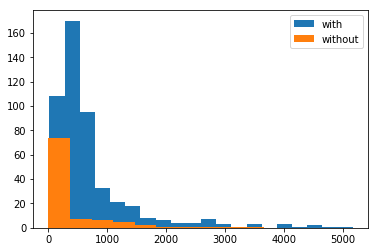

In [4]:
# Show reward distribution info

print('The number of samples with radiation: ', len(days_to_death_with_radiation))
print('Median: ', np.median(days_to_death_with_radiation), ' Mean: ', np.mean(days_to_death_with_radiation))
print()
print('The number of samples without radiation: ', len(days_to_death_without_radiation))
print('Medians: ', np.median(days_to_death_without_radiation), ' Mean: ', np.mean(days_to_death_without_radiation))

plt.hist(days_to_death_with_radiation, bins = 20, label = 'with')
plt.hist(days_to_death_without_radiation, bins = 10, label = 'without')
plt.legend()

### Setup Environment

In [5]:
# setting

num_rounds = 300
num_exper = 1000
num_arms = 2

# environment

clinical_envs = defaultdict(list)
medians = defaultdict(list)

clinical_envs['radiation'] = [Clinical_env(days_to_death_with_radiation),
                              Clinical_env(days_to_death_without_radiation)
                             ]

medians['radiation'] = [np.median(days_to_death_with_radiation),
                        np.median(days_to_death_without_radiation)
                       ]

policy = UCB_clinical

# hyper-parameters for policy

hyperpara_list = [[4, 1]]

evaluation = ['sd', 'r', 'bd']

In [6]:
clinical_envs

defaultdict(list,
            {'radiation': [<Environment.Clinical_env at 0x7fb8cb437f60>,
              <Environment.Clinical_env at 0x7fb8cb437c88>]})

In [7]:
results = defaultdict(dict)

for key in clinical_envs.keys():
    for hyperpara in hyperpara_list:
        for est_flag in [False]:
            name = key + '_' + str(num_exper) + '_' + str(num_rounds) 
            subname = str(est_flag)+ str(hyperpara)
            print(name + subname)
            p = IntProgress(max = num_exper)
            p.description = 'Running'
            display(p)
            results[name][subname], results[name]['bound']= \
                    simulate(clinical_envs[key], medians[key], policy, num_exper, num_rounds, est_flag, hyperpara, evaluation, p)

radiation_1000_300False[4, 1]


IntProgress(value=0, description='Running', max=1000)

In [8]:
hyperpara_list = [[1]]
est_var = False

for key in clinical_envs.keys():
    for hyperpara in hyperpara_list:
        name = key + '_' + str(num_exper) + '_' + str(num_rounds)
        subname = 'UCB1_' + str(hyperpara)
        print(name + subname)
        p = IntProgress(max = num_exper)
        p.description = 'Running'
        display(p)
        results[name][subname], bounds= simulate(clinical_envs[key], medians[key], UCB1_os_clinical, num_exper, num_rounds, est_var, hyperpara, evaluation, p)
    


radiation_1000_300UCB1_[1]


IntProgress(value=0, description='Running', max=1000)

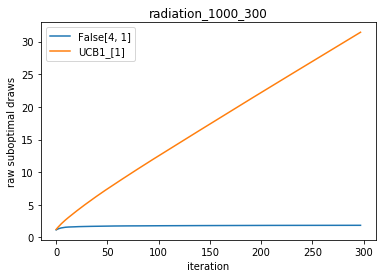

In [9]:
plots.plot_eva(results, 'sd', 'raw', compare_flag = True)

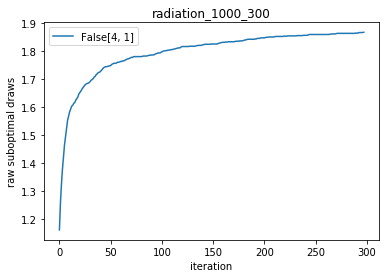

In [10]:
plots.plot_eva(results, 'sd', 'raw', compare_flag = False)

The plots shows our policy performs good in terms of this application.

Note: 

the lower bound of hazard rate estimation (L) in this experiment is not calculated by L = h(0) = f(0)/(1 - F(0)) since we don't know the experssion of distributions. To estimate it, we use #(X < 1)

In [11]:
import pickle 
saving = results

with open('os_saving_7.pickle', 'wb') as handle:
    pickle.dump(saving, handle, protocol=pickle.HIGHEST_PROTOCOL)